# Application 1:  a simple nested cube with no preconditioner

In [1]:
import bempp.api
bempp.api.__version__

'3.3.5'

In [2]:
# PARAMETERS

## PHYSICS
k = {
    'e': 1,
    'i': 1,
    'w': 1,
}

mu = 1

## COMPUTING
element_size = 0.5

length_cavity = 1
length_wall = 2

DOMAIN = "RWG"  # RWG
RANGE = "BC" # # BC
DUAL_TO_RANGE = "SNC" # SNC

MDOMAIN = "BC"
MRANGE = "BC"
MDTR = "B-SNC"

# The type of space. Currently, the following types
# are supported:
#     "P" : Continuous and piecewise polynomial functions.
#     "DP" : Discontinuous and elementwise polynomial functions.
#     "RT": Raviart-Thomas Vector spaces.
#     "RWG": RWG Vector spaces.
#     "NC": Nedelec Vector spaces.
#     "SNC": Scaled Nedelec Vector spaces. The Nedelec basis functions
#            are scaled with the edge length so that they are identical
#            to RWG functions crossed with the element normals.

#     "B-P": Polynomial spaces on barycentric grids.
#     "B-DP": Polynomial discontinuous spaces on barycentric grids.
#     "B-RT": Raviart-Thomas Vector spaces on barycentric grids.
#     "B-RWG": RWG Vector spaces on barycentric grids.
#     "B-NC": Nedelec Vector spaces on barycentric grids.
#     "B-SNC": Scaled Nedelec Vector spaces on barycentric grids.

#     "DUAL": Dual space on dual grid (only implemented for constants).
#     "BC": Buffa-Christian Vector space.
#     "RBC": Rotated Buffa-Christian Vector space of curl-conforming
#            functions.

# Imports

In [3]:
import time
from collections import namedtuple
import numpy as np
import bempp.api

from bempp.api import shapes
from bempp.api import function_space, assembly
from bempp.api.operators.boundary import maxwell
from bempp.api.operators.potential import maxwell as maxwell_potential


from bempp.core.common.global_parameters import global_parameters # Interface to define global_parameters for operators

bempp.api.set_ipython_notebook_viewer()

# Create grid

This problem domain consists of two cubes: one large and one small. The small cube is positioned at the center of the large cube.

In [4]:
def discretize(grid, *methods_list):
    """
    Returns a named tuple containing the discretised boundaries of the
    given grid according to the method specified.
    """
    space = {}
    methods = list(set(methods_list))
    assert len(methods) > 0, "You must provide disretisation methods."
    for method_key in methods:
        method = method_key.split(".")[0]
#         if method == 'BC':
#             space[method_key] = function_space(grid.barycentric_grid(), 'BC', 0)
#         else:
#             space[method_key] = function_space(grid, method, 0)
        space[method_key] = function_space(grid, method, 0)
    return space


def make_spaces(grid):
    """
    Creates a function space for the grid for every
    space type specified.
    """
    return discretize(
        grid,
        DOMAIN,
        RANGE,
        DUAL_TO_RANGE,
        MDOMAIN,
        MRANGE,
        MDTR
    )

small_grid = shapes.cube(
        length=length_cavity, h=element_size,
        origin=(-length_cavity/2, -length_cavity/2, -length_cavity/2)
)

large_grid = shapes.cube(
        length=length_wall, h=element_size,
        origin=(-length_wall/2, -length_wall/2, -length_wall/2)
)

small_cube = make_spaces(small_grid)
large_cube = make_spaces(large_grid)

In [5]:
_ = small_cube[DOMAIN]
_.grid

In [6]:
x = large_cube[DOMAIN]
print(
    x.domain_dimension,
    x.global_dof_count,
    x.flat_local_dof_count,
    sep='\n'
)
y = small_cube[DOMAIN]
print(
    y.domain_dimension,
    y.global_dof_count,
    y.flat_local_dof_count,
    sep='\n'
)
print()
print(x.global_dof_count+y.global_dof_count)
print(x.flat_local_dof_count+y.flat_local_dof_count)

2
390
780
2
126
252

516
1032


In [7]:
wave_length_w = 2 * np.pi/k['w']
wave_length_w

6.283185307179586

In [8]:
wave_length_e = 2 * np.pi/k['e']
wave_length_e

6.283185307179586

In [9]:
wave_length_w/element_size

12.566370614359172

# Setup the Operator

$$
\mathcal{A}
=
\begin{bmatrix}
    -(\mathcal{A}^w_1 + \mathcal{A}^1_1) & \mathcal{A}^w_{1,w} \\
    -\mathcal{A}^w_{w,1}               & \mathcal{A}^w_w + \mathcal{A}^e_w \\
\end{bmatrix}
$$

In [10]:
def to_block_op(mfie, efie, k, mu):
    """
    Build the standard block operator from the given integral equations.
    """
    A = assembly.BlockedOperator(2, 2) # empty operator object
    A[0,0] = mfie
    A[0,1] = mu/k * efie
    A[1,0] = -k/mu * efie
    A[1,1] = mfie
    return A


def get_simple_block_op(space, k, mu):
    """
    Return a 2x2 block operator defining the block matrix that would
    act on the given grid.
    
    This is similar to the `multitrace_operator` constructor, but it
    allows us to specify exactly which boundary disretisation functions
    to use.
    """
#     efie = maxwell.electric_field(
#         space[DOMAIN], space[RANGE], space[DUAL_TO_RANGE], k,
#     )
#     mfie = maxwell.magnetic_field(
#         space[DOMAIN], space[RANGE], space[DUAL_TO_RANGE], k,
#     )
#     A = to_block_op(mfie, efie, k, mu)
#     return A
    grid = space[DOMAIN].grid
    return maxwell.multitrace_operator(grid, k)



def get_mixed_block_op(target, source, k, mu):
    """
    Return a 2x2 block operator that defines the interferences on
    `grid_a` by `grid_b`.
    """
#     efie = maxwell.electric_field(
#         source[DOMAIN], target[RANGE], target[DUAL_TO_RANGE], k
#     )
#     mfie = maxwell.magnetic_field(
#         source[DOMAIN], target[RANGE], target[DUAL_TO_RANGE], k
#     )
#     A = to_block_op(mfie, efie, k, mu)
#     return A
    source_grid = source[DOMAIN].grid
    target_grid = target[DOMAIN].grid
    return maxwell.multitrace_operator(source_grid, k, target=target_grid) 
    

def assign_inplace_subblock(A, a, i, j):
    """
    Assigns the 4 elements of a to the 2x2 block of A
    specified by the indexes i and j.
    """
    bi = 2*i
    bj = 2*j
    A[bi, bj]     = a[0, 0]
    A[bi, bj+1]   = a[0, 1]
    A[bi+1, bj]   = a[1, 0]
    A[bi+1, bj+1] = a[1, 1]
    

def PMCHWT_operator(
        small_cube, large_cube, k_int, k_wal, k_ext, mu, parameters
    ):
    """Vector = namedtuple('Vector', ['neumann', 'dirichlet'])
    Build the operator for the nested shape problem formulation.
    """
    # small cube
    A1_1 = get_simple_block_op(small_cube, k_int, mu)
    Aw_1 = get_simple_block_op(small_cube, k_wal, mu)
    # large cube
    Aw_w = get_simple_block_op(large_cube, k_wal, mu)
    Ae_w = get_simple_block_op(large_cube, k_ext, mu)
    # mixed (target, source, k)
    Aw_1w = get_mixed_block_op(small_cube, large_cube, k_wal, mu)
    Aw_w1 = get_mixed_block_op(large_cube, small_cube, k_wal, mu)
   
    # assemble the blocks
    A = assembly.BlockedOperator(2 * 2, 2 * 2)
    assign_inplace_subblock(A, -(Aw_1 + A1_1), 0, 0)
    assign_inplace_subblock(A,   Aw_1w,        0, 1)
    assign_inplace_subblock(A, - Aw_w1,        1, 0)
    assign_inplace_subblock(A,   Aw_w + Ae_w,  1, 1)
    
    return A

    
A = PMCHWT_operator(small_cube, large_cube, k['i'], k['w'], k['e'], mu, None)

In [12]:
def build_diagonal(small_cube, large_cube, k_int, k_wal, k_ext, mu, parameters):
    """
    Assemble the operator which is equivalent to the diagonal of A
    """
    # small cube
    A1_1 = get_simple_block_op(small_cube, k_int, mu)
    Aw_1 = get_simple_block_op(small_cube, k_wal, mu)
    # large cube
    Aw_w = get_simple_block_op(large_cube, k_wal, mu)
    Ae_w = get_simple_block_op(large_cube, k_ext, mu)
    # mixed (target, source, k)
#     Aw_1w = get_mixed_block_op(small_cube, large_cube, k_wal, mu)
#     Aw_w1 = get_mixed_block_op(large_cube, small_cube, k_wal, mu)
   
    # assemble the blocks
    D = assembly.BlockedOperator(2 * 2, 2 * 2)
    assign_inplace_subblock(D, -(Aw_1 + A1_1), 0, 0)
#     assign_inplace_subblock(A,   Aw_1w,        0, 1)
#     assign_inplace_subblock(A, - Aw_w1,        1, 0)
    assign_inplace_subblock(D,   Aw_w + Ae_w,  1, 1)
    
    return D

D = build_diagonal(small_cube, large_cube, k['i'], k['w'], k['e'], mu, None)

In [13]:
spaces_in_A = [d.flat_local_dof_count for d in A._range_spaces]
print(*[d for d in A._domain_spaces], sep='\n')
print(spaces_in_A)
print(sum(spaces_in_A))

[1512, 2904, 4680, 9312]
18408


# Discretize the incident field

In [14]:
def incident_field(x):
    return np.array([0. * x[2], 0. * x[2], np.exp(1j * k['e'] * x[0])])


def dirichlet_trace_fun(x, n, domain_index, result):
    result[:] = np.cross(incident_field(x), n)

    
def curl(incident_field,x):
    return np.array([0,  - 1j * k['e'] * np.exp(1j * k['e'] * x[0]), 0])


def neumann_trace_fun(x, n, domain_index, result):
    result[:] = (1/(1j * k['e'])) * np.cross(curl(incident_field,x), n)


# for large cube
Dtrace_inc = bempp.api.GridFunction(
    large_cube[DOMAIN],
#     large_cube[DUAL_TO_RANGE],
    fun=dirichlet_trace_fun
)
Ntrace_inc = (k['e']/mu) * bempp.api.GridFunction(
    large_cube[DOMAIN],
#     large_cube[DUAL_TO_RANGE],
    fun=neumann_trace_fun
)
# combine
Vector = namedtuple('Vector', ['dirichlet', 'neumann'])
u_inc = Vector(
    Dtrace_inc.coefficients.tolist(),
    Ntrace_inc.coefficients.tolist()
)

In [15]:
# theta = np.pi / 4 # Incident wave travelling at a 60 degree angle
# direction = np.array([np.cos(theta), 0, np.sin(theta)])
# polarization = np.array([0, 1.0, 0])

# def plane_wave(point):
#     return polarization * np.exp(1j * k_ext * np.dot(point, direction))

# def dirichlet_trace_fun(point, n, domain_index, result):
#     result[:] =  np.cross(plane_wave(point), n)

# def plane_wave_curl(point):
#     return np.cross(direction, polarization) * 1j * k_ext * np.exp(1j * k_ext * np.dot(point, direction))

# def neumann_trace_fun(point, n, domain_index, result):
#     result[:] =  1./ (1j * k_ext) * np.cross(plane_wave_curl(point), n)

In [16]:
print(len(u_inc[0]))
print(len(u_inc[1]))

390
390


# Assemble the RHS

$$
f = \begin{bmatrix}
    - \mathcal{A_{1w}} \\
    - (\mathcal{A_{w}} - \frac{1}{2} \mathcal{I})
\end{bmatrix}
$$

In [24]:
def get_identity_op(space):
    """
    Shortcut to the sparse identity operator.
    """
#     return bempp.api.operators.boundary.sparse.identity(
#         # this can make the kernel crash if not set correctly
#         space[DOMAIN], space[RANGE], space[DUAL_TO_RANGE]
#     )
    return bempp.api.operators.boundary.sparse.multitrace_identity(
        space[DOMAIN].grid, spaces='maxwell')
    

# def get_zero_op(space):
#     """
#     Shortcut to the boundary zerop operator.
#     """
#     return bempp.api.ZeroBoundaryOperator(
#         space[DOMAIN], space[RANGE], space[DUAL_TO_RANGE]
#     )


def get_block_identity_op(space):
    """
    Create an identity operator matching the given space.
    """
    i = get_identity_op(space)
#     o = get_zero_op(space)
    I = assembly.BlockedOperator(2, 2)
    I[0, 0] = i;
#     I[0, 1] = o
#     I[1, 0] = o;
    I[1, 1] = i
    return I
    

Aw_1w = get_mixed_block_op(small_cube, large_cube, k['w'], mu)
Aw_w  = get_simple_block_op(large_cube, k['w'], mu)
# I = get_block_identity_op(large_cube)

In [19]:
print([d.flat_local_dof_count for d in Aw_1w._domain_spaces])
print([d.flat_local_dof_count for d in Aw_1w._range_spaces])
print([d.flat_local_dof_count for d in Aw_w._domain_spaces])
print([d.flat_local_dof_count for d in Aw_w._range_spaces])

[4680, 9312]
[1512, 2904]
[4680, 9312]
[4680, 9312]


In [20]:
def flatten(vector):
    return vector[0] + vector[1]

pre = [
    - Aw_1w.weak_form() * flatten(u_inc),
    - (Aw_w.weak_form() - 1/2 * I.weak_form()) * flatten(u_inc)
]
# flatten list of lists
f = [y for x in pre for y in x]

NameError: name 'I' is not defined

In [ ]:
# b = [
#     - (Aw_1w[0, 0].weak_form() * Dtrace_inc.coefficients + Aw_1w[0, 1].weak_form() * Ntrace_inc.coefficients),
#     - (Aw_1w[1, 0].weak_form() * Dtrace_inc.coefficients + Aw_1w[1, 1].weak_form() * Ntrace_inc.coefficients),
#     - ((Aw_w[0, 0].weak_form() - 1/2 * I[0, 0].weak_form()) * Dtrace_inc.coefficients + (Aw_w[0, 1].weak_form()) * Ntrace_inc.coefficients),
#     - ((Aw_w[1, 0].weak_form()) * Dtrace_inc.coefficients + (Aw_w[1, 1].weak_form() - 1/2 * I[1, 1].weak_form()) * Ntrace_inc.coefficients),
# ]
# b = [
#     bempp.api.GridFunction(small_cube[DOMAIN], coefficients=b[0]),
#     bempp.api.GridFunction(small_cube[DOMAIN], coefficients=b[1]),
#     bempp.api.GridFunction(large_cube[DOMAIN], coefficients=b[2]),
#     bempp.api.GridFunction(large_cube[DOMAIN], coefficients=b[3]),
# ]

In [25]:
I = get_identity_op(large_cube)
b = [
    - Aw_1w * [Dtrace_inc, Ntrace_inc],
    - (Aw_w - 1/2 * I) * [Dtrace_inc, Ntrace_inc]
]
b = [y for x in b for y in x]

# Define the Mass Matrix

In [26]:
# Antigoni's code
if False:
    mass_matrix_BC_SNC = np.empty((2 * number_of_scatterers, 2 * number_of_scatterers), dtype='O')
    id_BRWG_RBC = bempp.api.operators.boundary.sparse.identity(b_rwg_space[i], b_rwg_space[i], rbc_space[i])
    inv_identity_BRWG_RBC = bempp.api.assembly.InverseSparseDiscreteBoundaryOperator(id_BRWG_RBC.weak_form())
    mass_matrix_BRWG_RBC[2*i, 2*j] = inv_identity_BRWG_RBC
    mass_matrix_BRWG_RBC[2*i + 1, 2*j+1] = inv_identity_BRWG_RBC
    mass_matrix_BRWG_RBC = bempp.api.assembly.BlockedDiscreteOperator(mass_matrix_BRWG_RBC)

In [ ]:
M = np.empty((2 * 2, 2 * 2), dtype='O')
# small_I = get_identity_op(small_cube)
# large_I = get_identity_op(large_cube)
small_I = bempp.api.operators.boundary.sparse.identity(
    # this can make the kernel crash if not set correctly
#         DOMAIN, RANGE, DUAL_TO_RANGE
    small_cube[MDOMAIN], small_cube[MDOMAIN], small_cube[MDTR] # function spaces
)
large_I = bempp.api.operators.boundary.sparse.identity(
    # this can make the kernel crash if not set correctly
    large_cube[MDOMAIN], large_cube[MDOMAIN], large_cube[MDTR]
)
inv_small_I = assembly.InverseSparseDiscreteBoundaryOperator(small_I.weak_form())
inv_large_I = assembly.InverseSparseDiscreteBoundaryOperator(large_I.weak_form())

M[0, 0] = inv_small_I
M[1, 1] = inv_small_I
M[2, 2] = inv_large_I
M[3, 3] = inv_large_I

M = bempp.api.assembly.BlockedDiscreteOperator(M)

# Make choice of Preconditioning type

In [35]:
Operator = namedtuple('Operator', ['name', 'lhs', 'rhs'])
Result = namedtuple('Result', ['x', 'info', 'residuals'])

In [34]:
operators = [
    Operator(
       'None',  # Name 
        A.weak_form(), # LHS
        f # RHS
    ),
    Operator(
       'M',
        M * A.weak_form(),
        M * f
    ),
#     Operator(
#         'A',
#         A.weak_form() * M * A.weak_form(),
#         A.weak_form() * M * f
#     ),
#     Operator(
#         'D',
#         D.weak_form() * M * A.weak_form(),
#         D.weak_form() * M * f
#     ),
]

NameError: name 'f' is not defined

# Solve the Linear System

## Weak Form

In [27]:
from antigoni.login import gmres

In [28]:
# In the last run this stoped convergin around i=4000
# consider setting maxiter to this number for testing
# x, info, residuals = gmres(LHS, RHS, return_residuals=True, maxiter=200)

In [30]:
operators = []

In [31]:
results = {
    op.name: Result(
        *gmres(
            op.lhs, op.rhs,
            return_residuals=True,
            maxiter=500
        )
    )
    for op in operators
} 

## Built In Strong Form

In [36]:
# This can cause the kernel to fail

x, info, residuals = bempp.api.linalg.gmres(
    A, b,
    use_strong_form=True,
    return_residuals=True,
    maxiter=500
)

In [37]:
x = np.hstack([c.coefficients for c in x])
results['Built-In Strong'] = Result(x, info, residuals)

# Plot

## Residual

In [38]:
import matplotlib.pyplot as plt

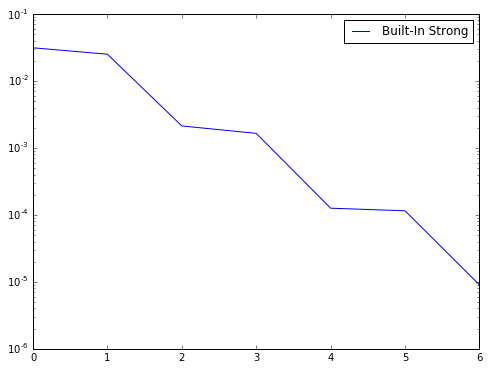

In [39]:
for name, result in results.items():
    plt.semilogy(result.residuals, label=name)
plt.legend()
fig = plt.gcf()
fig.set_size_inches(8, 6)
# fig.dpi = 100

## Split result into each domain and then into Neumann and Dirichlet traces

In [42]:
PRECON_TYPE = 'Built-In Strong'

x = results[PRECON_TYPE].x
# Split between different domains in vector
u_cavity = Vector(
    dirichlet=x[:small_cube[DOMAIN].flat_local_dof_count//2],
    neumann=x[small_cube[DOMAIN].flat_local_dof_count//2:small_cube[DOMAIN].flat_local_dof_count]
)

split_point = small_cube[DOMAIN].flat_local_dof_count

u_scattered = Vector(
    dirichlet=x[split_point:split_point+large_cube[DOMAIN].flat_local_dof_count//2],
    neumann=x[split_point+large_cube[DOMAIN].flat_local_dof_count//2:]
)

# Check
def assert_lengths_match(a, b):
    """
    Raise Error if lengths of a and b do not match.
    """
    if isinstance(a, int):
        va = a
    else:
        va = len(a)
    
    if isinstance(b, int):
        vb = b
    else:
        vb = len(b)
        
    assert va == vb, "Lengths must match. Got %i and %i." % (va, vb)

    
# assert_lengths_match(
#     sum([len(z) for z in [
#         u_cavity.neumann, u_cavity.dirichlet,
#         u_scattered.neumann, u_scattered.dirichlet
#     ]]),
#     f
# )

# assert_lengths_match(*u_cavity)
# assert_lengths_match(*u_scattered)

## Get the trace of the field in the wall from the scattered and incident traces

In [43]:
u_wall = Vector(
    u_inc.dirichlet + u_scattered.dirichlet,
    u_inc.neumann + u_scattered.neumann,
)

## Define the points where we will evaluate the field

In [44]:
# Number of points in the x-direction
nx = 220# divide accordingly to achieve smaller particles

# Number of points in the y-direction
nz = 220

xmin, xmax, zmin, zmax = [
    -length_wall/2-1,
    length_wall/2+1,
    -length_wall/2-1,
    length_wall/2+1
] 
# Ask Antigoni, why j's
plot_grid = np.mgrid[xmin:xmax:nx * 1j, 0:0:1j, zmin:zmax:nz * 1j]

c = 0 # Intersecting plane

points = np.vstack((
    plot_grid[0].ravel(),
    c * np.ones(plot_grid[0].size),
    plot_grid[2].ravel()
))

# Compute interior and exterior indices
all_indices = np.ones(points.shape[1], dtype='uint32')

In [45]:
def point_is_within_cube(upper_bound_length, point):
    """
    Determines whether the given point is contained within the a centered cube with the
    bounds specified.
    """
    c =  [-upper_bound_length/2 < px and px < upper_bound_length/2
          for px in point]
    return all(c)
        
cavity_indexer = []
wall_indexer = []
exterior_indexer = []

for i, point in enumerate(points.T):
    if point_is_within_cube(length_cavity, point):
        cavity_indexer.append(i)
    elif point_is_within_cube(length_wall, point):
        wall_indexer.append(i)
    elif point_is_within_cube(np.inf, point):
        exterior_indexer.append(i)
    else:
        raise ValueError("Point %s not within domain" % point)

In [46]:
# Sanity check
print(
    len(cavity_indexer), '+',
    len(wall_indexer), '+',
    len(exterior_indexer), '=',
    sum([
        len(cavity_indexer),
        len(wall_indexer),
        len(exterior_indexer)
    ])
)

2916 + 9184 + 36300 = 48400


## Calculate the field form the trace data

In [47]:
# Cavity
cavity_points = points[:, cavity_indexer]

E_potential_op = maxwell_potential.electric_field(
    small_cube[DOMAIN], cavity_points, k['i'])
H_potential_op = maxwell_potential.magnetic_field(
    small_cube[DOMAIN], cavity_points, k['i'])

Ntrace_i = bempp.api.GridFunction(
    small_cube[DOMAIN], coefficients=u_cavity.neumann)
Dtrace_i = bempp.api.GridFunction(
    small_cube[DOMAIN], coefficients=u_cavity.dirichlet)

cavity_field =  H_potential_op * Dtrace_i + E_potential_op * (mu/k['i'] * Ntrace_i)

In [48]:
# Wall
wall_points = points[:, wall_indexer]

# Influence of external boundary
E_potential_op_w = maxwell_potential.electric_field(
    large_cube[DOMAIN], wall_points, k['w'])
H_potential_op_w = maxwell_potential.magnetic_field(
    large_cube[DOMAIN], wall_points, k['w'])

Ntrace_w = bempp.api.GridFunction(
    large_cube[DOMAIN], coefficients=u_wall.neumann)
Dtrace_w = bempp.api.GridFunction(
    large_cube[DOMAIN], coefficients=u_wall.dirichlet)

# Influence of cavity
E_potential_op_i = maxwell_potential.electric_field(
    small_cube[DOMAIN], wall_points, k['w'])
H_potential_op_i = maxwell_potential.magnetic_field(
    small_cube[DOMAIN], wall_points, k['w'])

# Putting them together
wall_field = H_potential_op_w * Dtrace_w + E_potential_op_w * (mu/k['w'] * Ntrace_w) \
    - (H_potential_op_i * Dtrace_i + E_potential_op_i * (mu/k['i'] * Ntrace_i))

In [49]:
# Scattered
exterior_points = points[:, exterior_indexer]

E_potential_op = maxwell_potential.electric_field(
    large_cube[DOMAIN], exterior_points, k['e'])
H_potential_op = maxwell_potential.magnetic_field(
    large_cube[DOMAIN], exterior_points, k['e'])

Ntrace = bempp.api.GridFunction(
    large_cube[DOMAIN], coefficients=u_scattered.neumann)
Dtrace = bempp.api.GridFunction(
    large_cube[DOMAIN], coefficients=u_scattered.dirichlet)

scattered_field = - H_potential_op * Dtrace - E_potential_op * (mu/k['e'] * Ntrace)

# Combine, Shape and Plot the Results

In [50]:
total_field = np.empty_like(points, dtype='complex128')

def get_field(selector, field):
    total_field = np.empty_like(points, dtype='complex128')
    total_field[:] = np.nan
    total_field[:, selector] = field
    return np.sum(np.abs(total_field**2), axis=0)

In [51]:
total_field[:, cavity_indexer] = cavity_field
total_field[:, wall_indexer] =  wall_field
total_field[:, exterior_indexer] = scattered_field + incident_field(points[:, exterior_indexer])
# squared_scattered_field = np.sum(np.abs(scattered_field)**2, axis=0)
squared_field = np.sum(np.abs(total_field**2), axis=0)

Built-In Strong


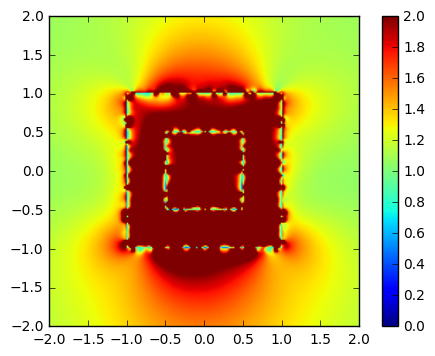

In [52]:
print(PRECON_TYPE)

def implot(data, clim=(0, 2)):
    """
    Plot on an axis the field data
    """
    im = plt.imshow(
        data.reshape(nx, nz),
        extent=[xmin, xmax, zmin, zmax],
        clim=clim,
    )
    fig = plt.gcf()
    plt.colorbar()
    fig.dpi = 100
    return x

implot(squared_field);

In [ ]:
print(PRECON_TYPE)

def implot(data, clim=(0, 2)):
    """
    Plot on an axis the field data
    """
    im = plt.imshow(
        data.reshape(nx, nz),
        extent=[xmin, xmax, zmin, zmax],
        clim=clim,
    )
    fig = plt.gcf()
    plt.colorbar()
    fig.dpi = 100
    return x

implot(squared_field);

In [ ]:
implot(get_field(wall_indexer, wall_field), clim=(0, 0.1));

In [ ]:
implot(get_field(cavity_indexer, cavity_field));